<center><h1>AI in Web Development</h1></center>

---

<center><h2>Lesson 04</h2></center>


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/snsie/ai-webdev/blob/main/lessons/lesson-04/lesson-04.ipynb)

This notebook is based on [this example](https://colab.research.google.com/github/ehennis/ReinforcementLearning/blob/master/05-DQN.ipynb#scrollTo=DPWjJiOZ2uVd) and [this example](https://colab.research.google.com/github/Curt-Park/rainbow-is-all-you-need/blob/master/01.dqn.ipynb)



<h1 align="center">Reinforcement Learning (RL)</h1>

<center><img src="https://github.com/snsie/ai-webdev/blob/main/images/what-is-reinforcement-learning.png?raw=true" width='320px'/></center>


###Environment
  * The stage that contains the simulation

<br/>

###Agent
  * The entity making decisions
  * Can be represented as a neural network

<br/>

###States
* Set of observations that agents that can be performed by the agent
* example: agent's position

<br/>

###Actions
* Set of activities that can be performed by the agent
* example: move right, move left

<br/>

###Rewards
* Provides agents feedback about their performance


<center><h1>Cart Pole Example</h1></center>

---

<center><h4>the cart's goal: balance the pole</h4></center>


[Gym Docs](https://www.gymlibrary.ml/environments/classic_control/cart_pole/)

|Bad Cart          |  Good Cart  |
|:-------------------------:|:-------------------------:|
| <img src='https://github.com/snsie/ai-webdev/blob/main/images/cartpole-initial.gif?raw=true' width="300"/>  | <img src='https://github.com/snsie/ai-webdev/blob/main/images/cartpole-trained.gif?raw=true' width="300"/> |

<center><h3><u>Actions</u></h3></center>

| Num | Action                 |
|-----|------------------------|
| 0   | Push cart to the left  |
| 1   | Push cart to the right |

<br/>
<br/>

<center><h3><u>States</u></h3></center>

| Num | Observation           | Min                 | Max               |
|-----|-----------------------|:-------------------|:-----------------|
| 0   | Cart Position         | -4.8                | 4.8               |
| 1   | Cart Velocity         | -Inf                | Inf               |
| 2   | Pole Angle            | ~ -0.418 rad (-24°) | ~ 0.418 rad (24°) |
| 3   | Pole Angular Velocity | -Inf                | Inf               |

<br/>

[Cart Pole Python File](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)

RL Algorithm to be used in this example:

<center><h1>Q-learning</h1></center>

<br/>

<h4>
\begin{align}
Q(s,a) = r(s,a) + \gamma \cdot \max_{a} Q(s',a')
\end{align}
</h4>

<br/>

###$Q(s,a)$ = Q-value

###$r(s,a)$ = reward for current action

###$\gamma$ = parameter that scales: $\max_{a}Q(s',a')$

###$\max_{a}Q(s',a')$ = Maximum Q-value predicted in the next state 

<br/>

---

<h3>Long term interpretation of Q:</h3>
<h3>
$$
Q(s_t,a_t) = r(t) + \gamma \cdot r(t+1) + \gamma^2 \cdot r(t+2) +  \gamma^3 \cdot r(t+3) \ ...
$$
</h3>

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gym==0.21.0
    from pyvirtualdisplay import Display
    
    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.


In [2]:
import os
from typing import Dict, List, Tuple

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

## Replay buffer

Typically, people implement replay buffers with one of the following three data structures:

  - collections.deque
  - list
  - numpy.ndarray
  
**deque** is very easy to handle once you initialize its maximum length (e.g. deque(maxlen=buffer_size)). However, the indexing operation of deque gets terribly slow as it grows up because it is [internally doubly linked list](https://wiki.python.org/moin/TimeComplexity#collections.deque). On the other hands, **list** is an array, so it is relatively faster than deque when you sample batches at every step. Its amortized cost of  *Get item* is [O(1)](https://wiki.python.org/moin/TimeComplexity#list).

Last but not least, let's see **numpy.ndarray**. numpy.ndarray is even faster than list due to the fact that it is [a homogeneous array of fixed-size items](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html#numpy.ndarray), so you can get the benefits of [locality of reference](https://en.wikipedia.org/wiki/Locality_of_reference). Whereas list is an array of pointers to objects, even when all of them are of the same type.

Here, we are going to implement a replay buffer using numpy.ndarray.


Reference: [OpenAI spinning-up](https://github.com/openai/spinningup/blob/master/spinup/algos/sac/sac.py#L10)

In [3]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(obs=self.obs_buf[idxs],
                    next_obs=self.next_obs_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs])

    def __len__(self) -> int:
        return self.size

## Network

We are going to use a simple network architecture with three fully connected layers and two non-linearity functions (ReLU).

In [4]:
class Network(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(Network, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_dim, 128), 
            nn.ReLU(),
            nn.Linear(128, 128), 
            nn.ReLU(), 
            nn.Linear(128, out_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        return self.layers(x)

## DQN Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |


In [5]:
class DQNAgent:
    """DQN Agent interacting with environment.
    
    Attribute:
        env (gym.Env): openAI Gym environment
        memory (ReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        epsilon (float): parameter for epsilon greedy policy
        epsilon_decay (float): step size to decrease epsilon
        max_epsilon (float): max value of epsilon
        min_epsilon (float): min value of epsilon
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including 
                           state, action, reward, next_state, done
    """

    def __init__(
        self, 
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.1,
        gamma: float = 0.99,
    ):
        """Initialization.
        
        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            epsilon_decay (float): step size to decrease epsilon
            lr (float): learning rate
            max_epsilon (float): max value of epsilon
            min_epsilon (float): min value of epsilon
            gamma (float): discount factor
        """
        obs_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n
        
        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        
        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # networks: dqn, dqn_target
        self.dqn = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target = Network(obs_dim, action_dim).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()
        
        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters())

        # transition to store in memory
        self.transition = list()
        
        # mode: train / test
        self.is_test = False

    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # epsilon greedy policy
        if self.epsilon > np.random.random():
            selected_action = self.env.action_space.sample()
        else:
            selected_action = self.dqn(
                torch.FloatTensor(state).to(self.device)
            ).argmax()
            selected_action = selected_action.detach().cpu().numpy()
        
        if not self.is_test:
            self.transition = [state, selected_action]
        
        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, done, _ = self.env.step(action)

        if not self.is_test:
            self.transition += [reward, next_state, done]
            self.memory.store(*self.transition)
    
        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()

        loss = self._compute_dqn_loss(samples)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()
        
    def train(self, num_frames: int, plotting_interval: int = 200):
        """Train the agent."""
        self.is_test = False
        
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        losses = []
        scores = []
        score = 0

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward

            # if episode ends
            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                losses.append(loss)
                update_cnt += 1
                
                # linearly decrease epsilon
                self.epsilon = max(
                    self.min_epsilon, self.epsilon - (
                        self.max_epsilon - self.min_epsilon
                    ) * self.epsilon_decay
                )
                epsilons.append(self.epsilon)
                
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()

            # plotting
            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, losses, epsilons)
                
        self.env.close()
                
    def test(self, video_folder: str) -> None:
        """Test the agent."""
        self.is_test = True
        
        # for recording a video
        naive_env = self.env
        self.env = gym.wrappers.RecordVideo(self.env, video_folder=video_folder)
        
        state = self.env.reset()
        done = False
        score = 0
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
        
        print("score: ", score)
        self.env.close()
        
        # reset
        self.env = naive_env

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray]) -> torch.Tensor:
        """Return dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # G_t   = r + gamma * v(s_{t+1})  if state != Terminal
        #       = r                       otherwise
        curr_q_value = self.dqn(state).gather(1, action)
        next_q_value = self.dqn_target(
            next_state
        ).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(self.device)

        # calculate dqn loss
        loss = F.smooth_l1_loss(curr_q_value, target)

        return loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())
                
    def _plot(
        self, 
        frame_idx: int, 
        scores: List[float], 
        losses: List[float], 
        epsilons: List[float],
    ):
        """Plot the training progresses."""
        clear_output(True)
        plt.figure(figsize=(20, 5))
        plt.subplot(131)
        plt.title('frame %s. score: %s' % (frame_idx, np.mean(scores[-10:])))
        plt.plot(scores)
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
        plt.subplot(133)
        plt.title('epsilons')
        plt.plot(epsilons)
        plt.show()

In [6]:
# environment
env_id = "CartPole-v0"
env = gym.make(env_id)

In [7]:
# #Hyper Parameters

# gamma=0.95

# learningRate=0.01

# batchSize=8

# numHiddenNodes=1024

# epsilonInit=0.8
# epsilon_min=0.001
# epsilon_decay=0.995
# parameters
num_frames = 10000
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = DQNAgent(env, memory_size, batch_size, target_update, epsilon_decay)

cpu


#Train

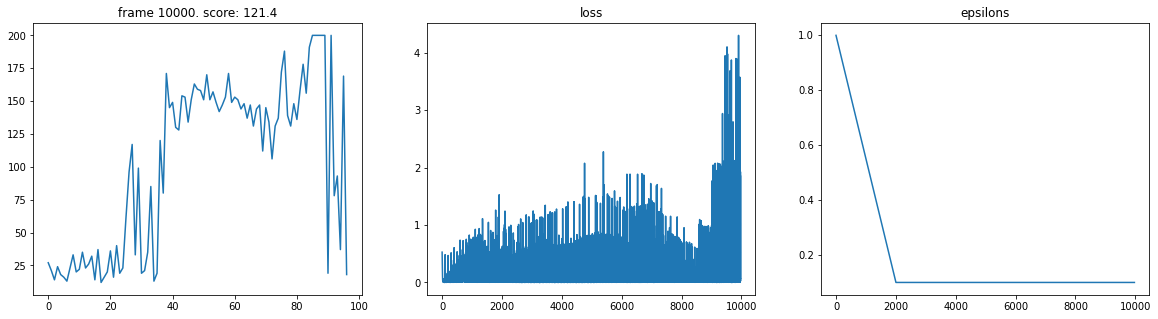

In [8]:
agent.train(num_frames)

#Test

In [9]:
video_folder="videos"
agent.test(video_folder=video_folder)

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


score:  200.0


In [10]:
import base64
import glob
import io
import os

from IPython.display import HTML, display


def ipython_show_video(path: str) -> None:
    """Show a video at `path` within IPython Notebook."""
    if not os.path.isfile(path):
        raise NameError("Cannot access: {}".format(path))

    video = io.open(path, "r+b").read()
    encoded = base64.b64encode(video)

    display(HTML(
        data="""
        <video width="320" height="240" alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4"/>
        </video>
        """.format(encoded.decode("ascii"))
    ))


def show_latest_video(video_folder: str) -> str:
    """Show the most recently recorded video from video folder."""
    list_of_files = glob.glob(os.path.join(video_folder, "*.mp4"))
    latest_file = max(list_of_files, key=os.path.getctime)
    ipython_show_video(latest_file)
    return latest_file


latest_file = show_latest_video(video_folder=video_folder)
print("Played:", latest_file)

Played: videos/rl-video-episode-0.mp4


**Reference**  
Mnih, V., Kavukcuoglu, K., Silver, D., Rusu, A. A., Veness, J., Bellemare, M. G., ... & Petersen, S. (2015). *Human-level control through deep reinforcement learning*. Nature, 518(7540), 529